In [1]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Downloading Faces data from Kaggle

In [2]:
!pip install opendatasets

In [4]:
import opendatasets as od

In [5]:
dataset = "https://www.kaggle.com/datasets/jessicali9530/lfw-dataset"

In [6]:
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rajeshveluguri
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset


100%|██████████| 112M/112M [00:00<00:00, 1.14GB/s]

In [9]:
import os

In [13]:
data_dir = 'lfw-dataset'

In [14]:
os.listdir(data_dir)

['pairs.csv',
 'people.csv',
 'mismatchpairsDevTrain.csv',
 'matchpairsDevTrain.csv',
 'peopleDevTrain.csv',
 'mismatchpairsDevTest.csv',
 'matchpairsDevTest.csv',
 'lfw_readme.csv',
 'lfw-deepfunneled',
 'lfw_allnames.csv',
 'peopleDevTest.csv']

In [17]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [18]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Split into a training set and a test and keep 25% of the data for testing.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [26]:
n_components = 500

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 500 eigenfaces from 966 faces
done in 4.770s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.142s


Train a SVM classification model

In [27]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 25.030s
Best estimator found by grid search:
SVC(C=np.float64(17056.95251110431), class_weight='balanced',
    gamma=np.float64(0.0002730272919464661))


Quantitative evaluation of the model quality on the test set

Predicting people's names on the test set
done in 0.148s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.77      0.61        13
     Colin Powell       0.65      0.88      0.75        60
  Donald Rumsfeld       0.68      0.63      0.65        27
    George W Bush       0.86      0.81      0.83       146
Gerhard Schroeder       0.69      0.44      0.54        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.77      0.64      0.70        36

         accuracy                           0.75       322
        macro avg       0.69      0.67      0.67       322
     weighted avg       0.76      0.75      0.74       322



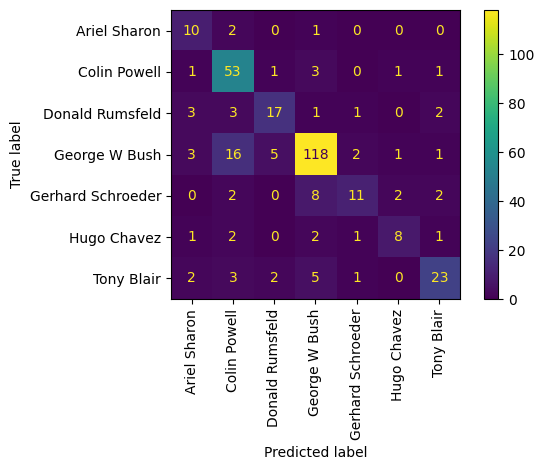

In [28]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Qualitative evaluation of the predictions using matplotlib

In [29]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

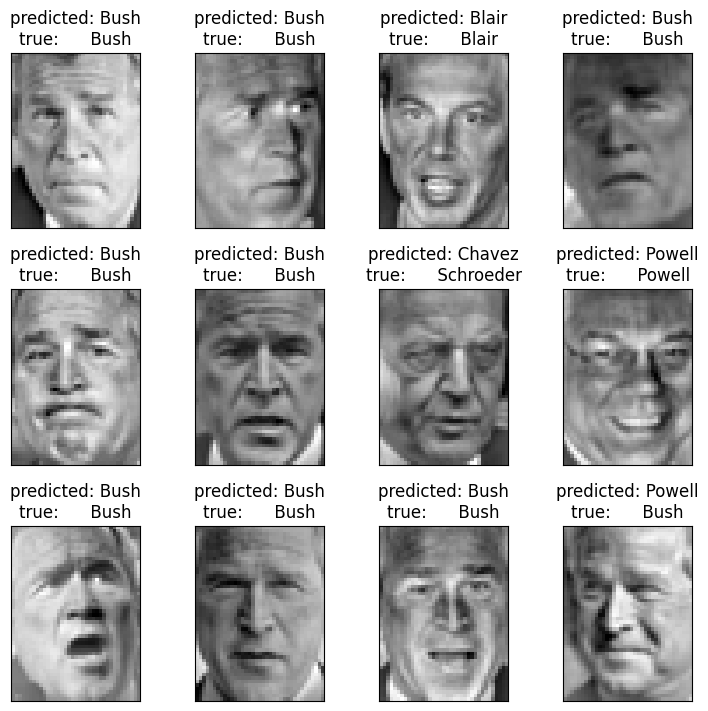

In [30]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

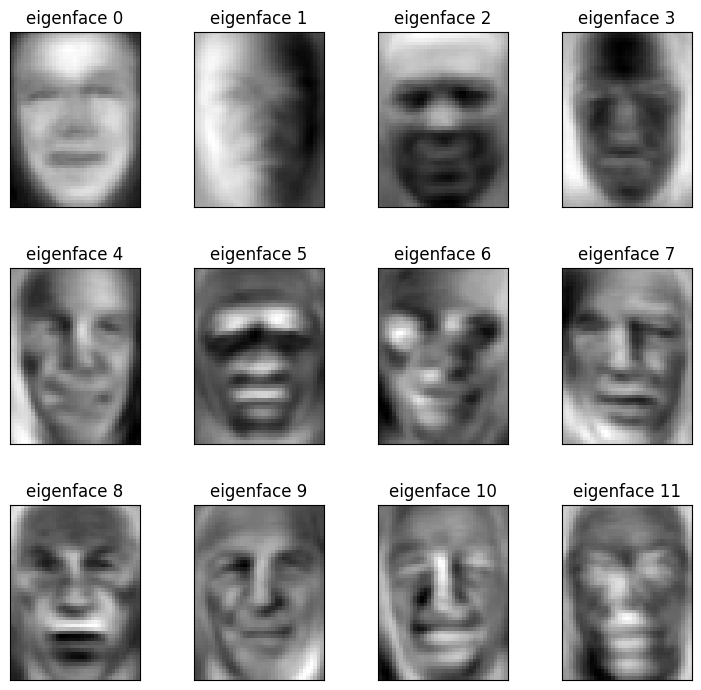

In [31]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()